# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f_app = os.path.join('./data', 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data\application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

Numbers of remain columns =  73


D:\Software\Anaconda\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
D:\Software\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
D:\Software\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
D:\Software\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
D:\Software\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)
D:\Software\Anaconda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplot

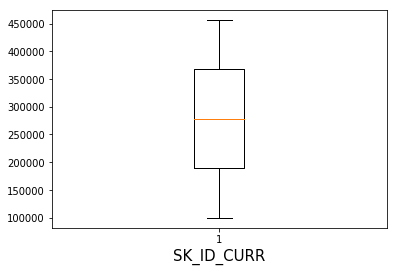

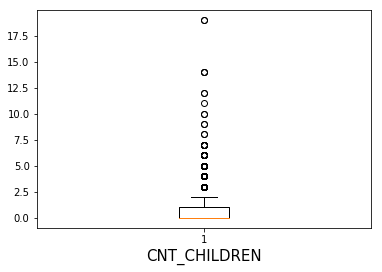

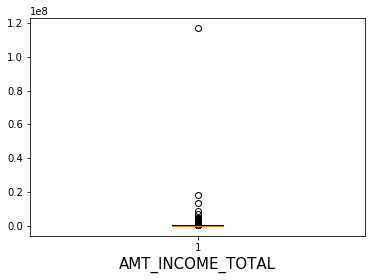

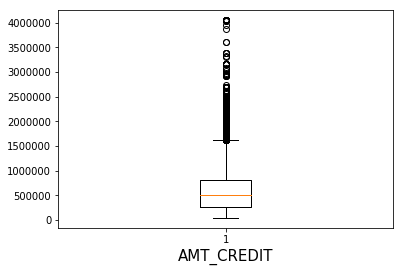

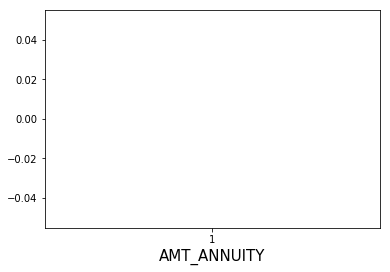

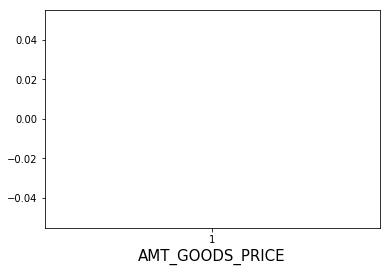

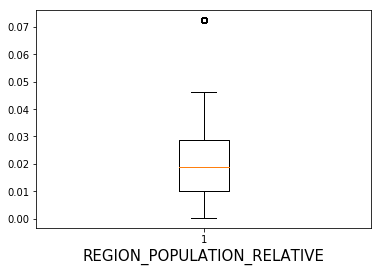

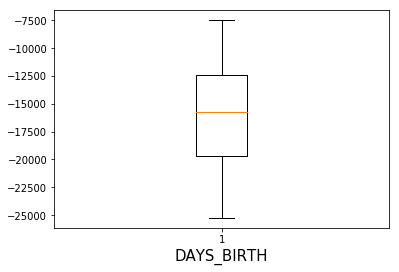

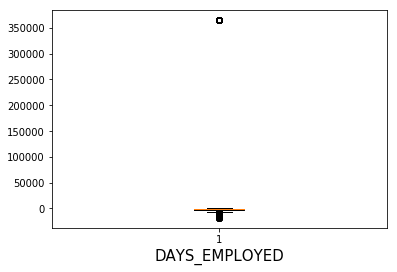

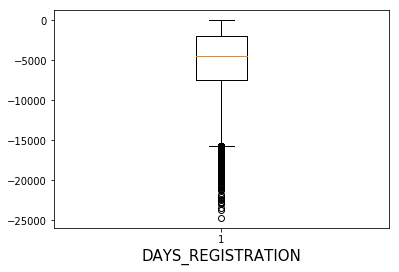

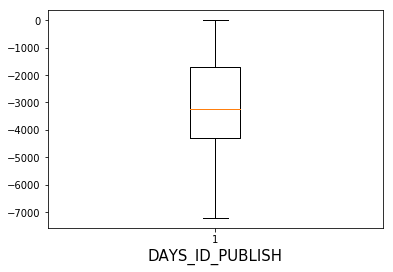

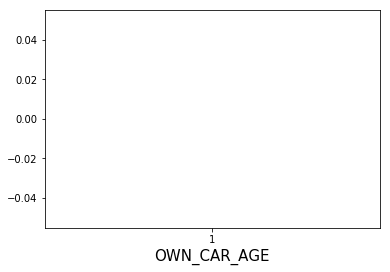

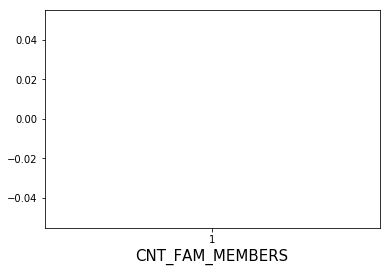

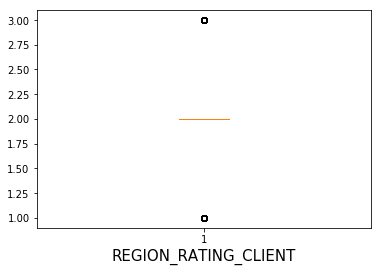

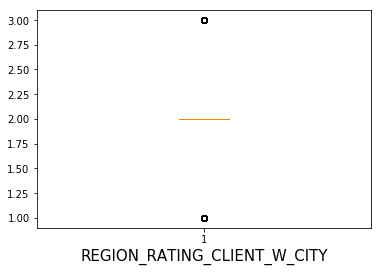

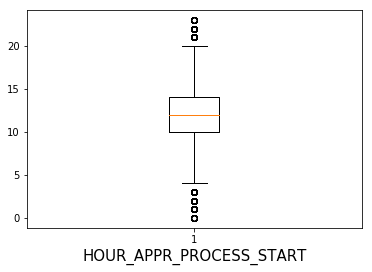

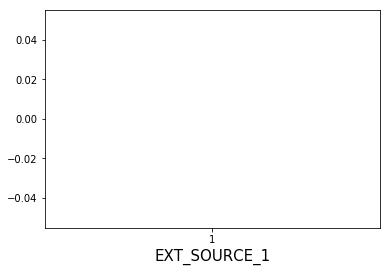

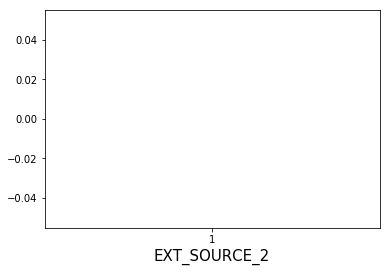

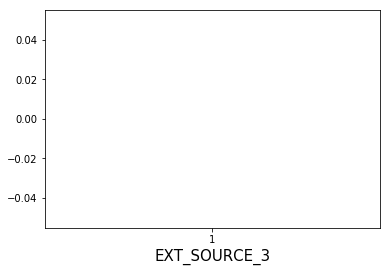

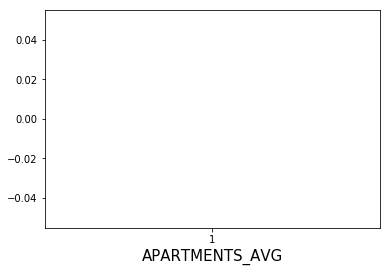

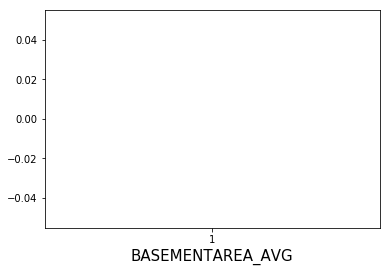

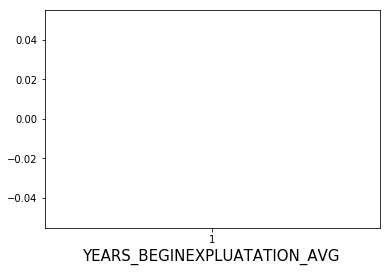

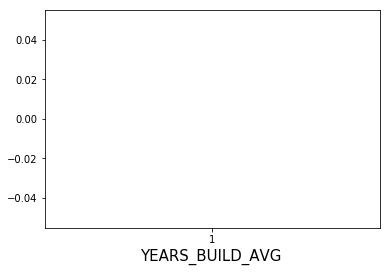

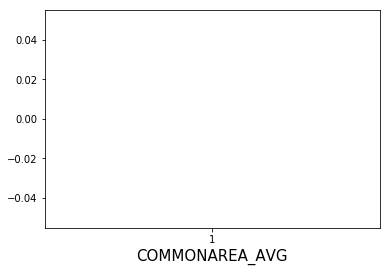

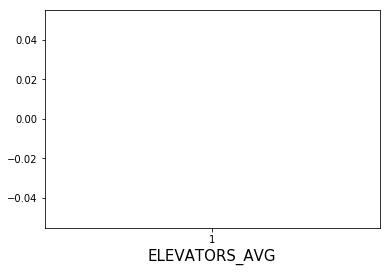

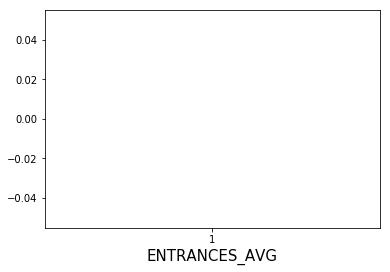

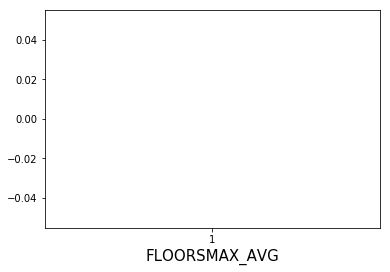

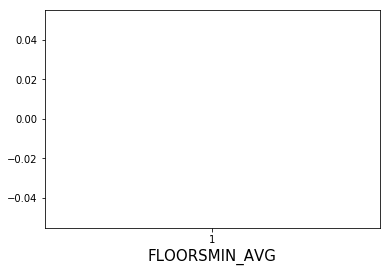

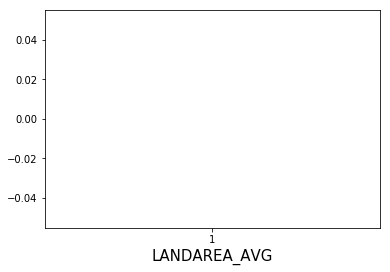

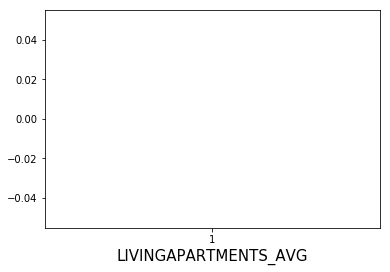

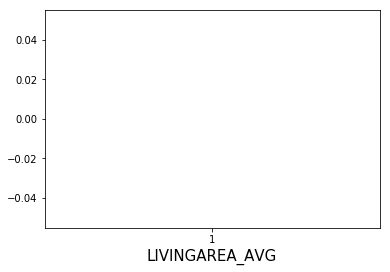

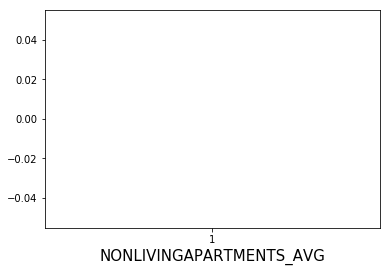

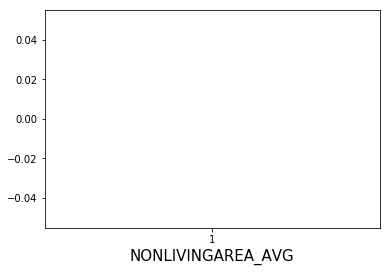

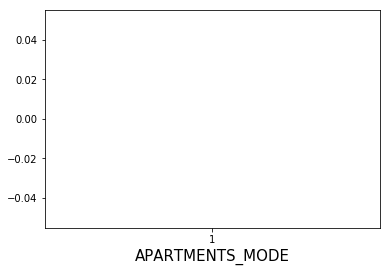

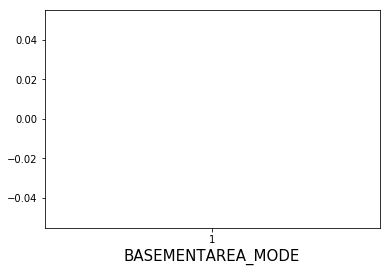

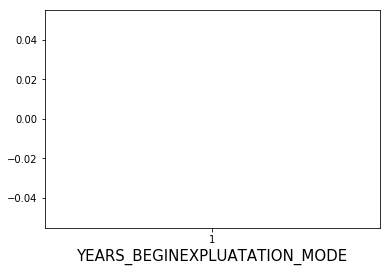

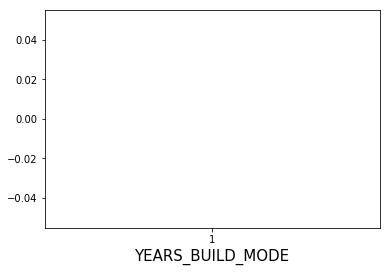

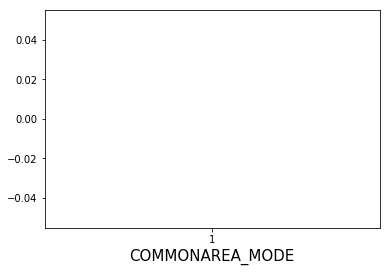

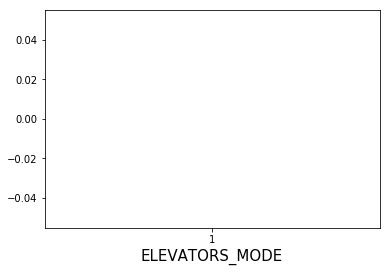

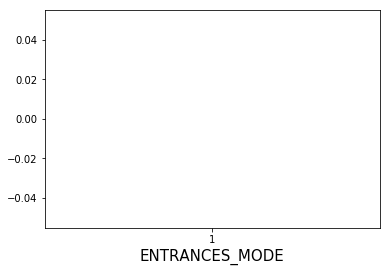

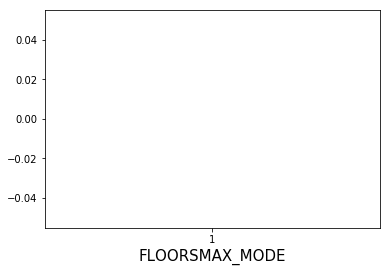

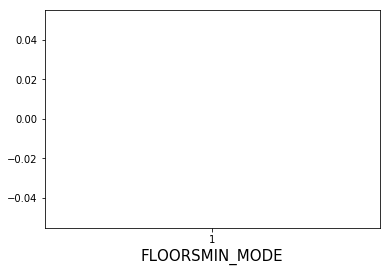

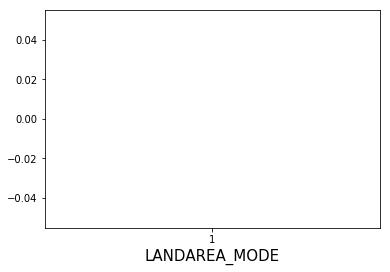

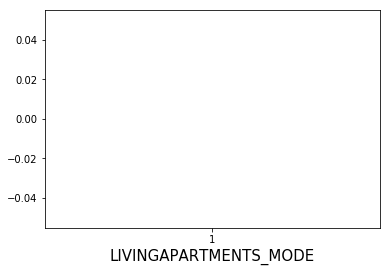

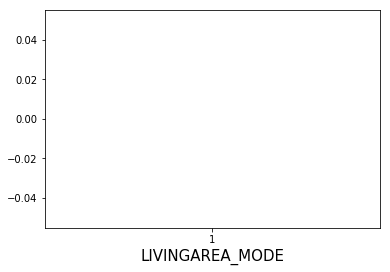

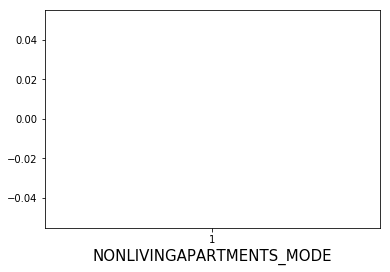

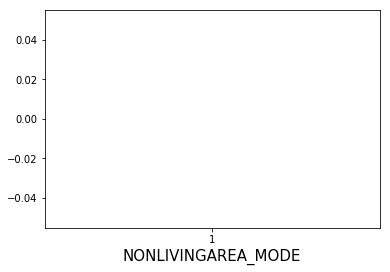

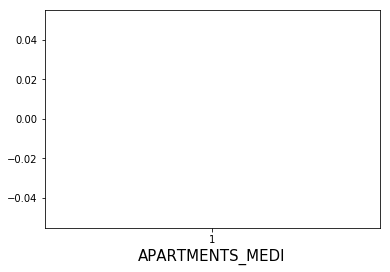

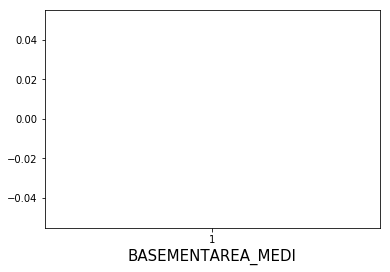

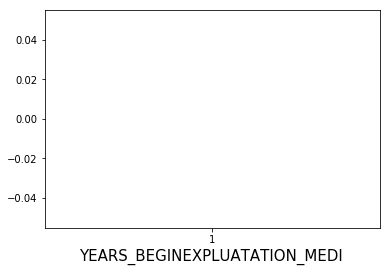

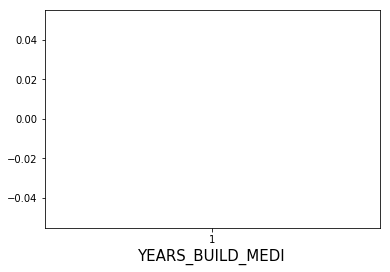

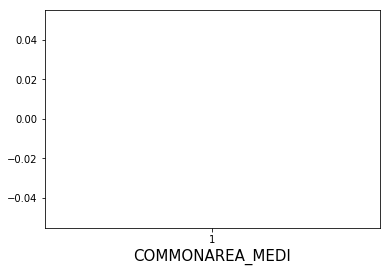

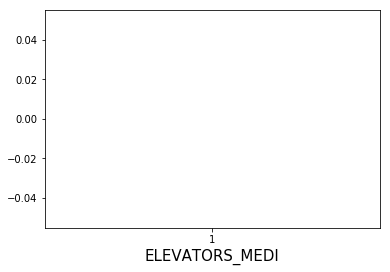

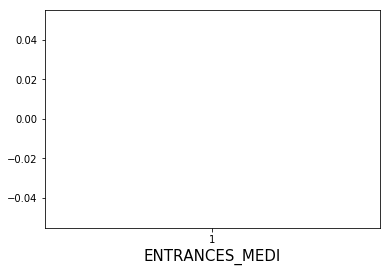

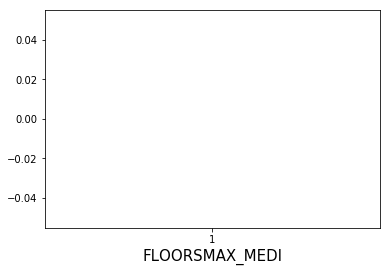

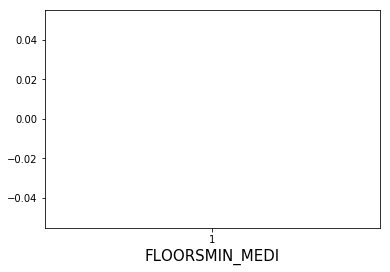

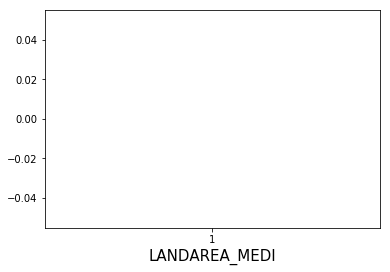

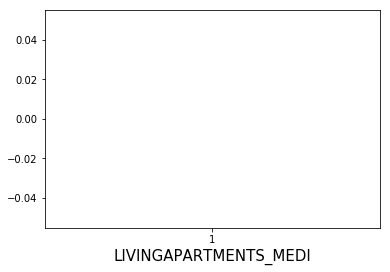

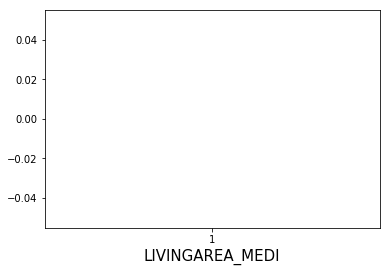

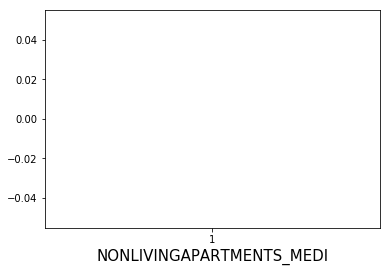

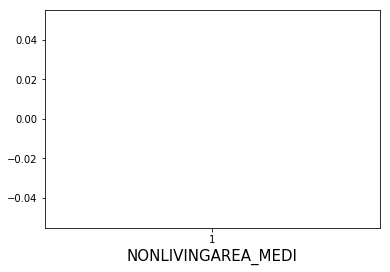

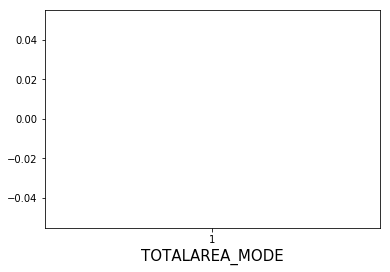

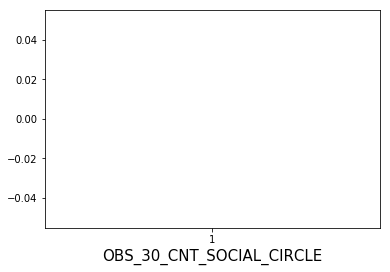

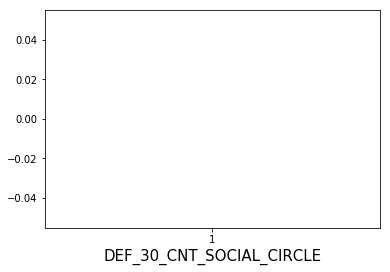

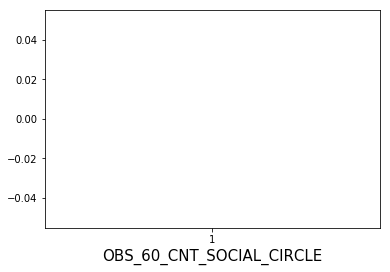

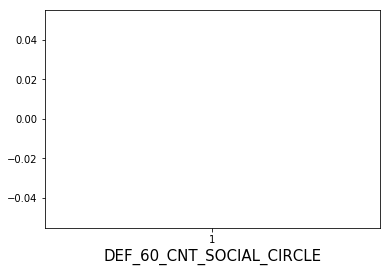

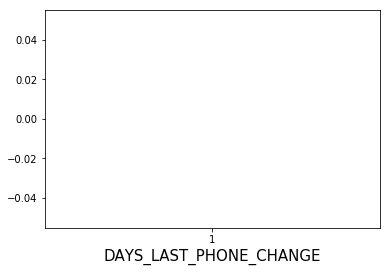

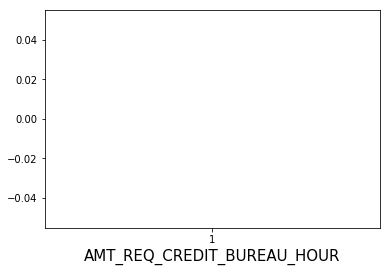

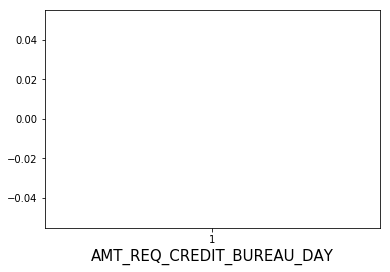

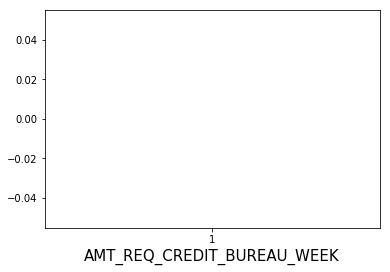

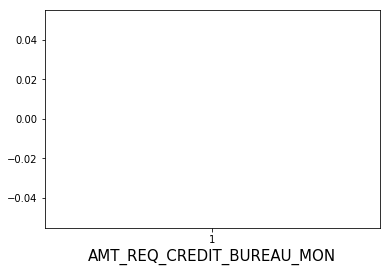

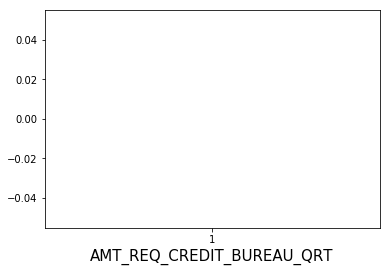

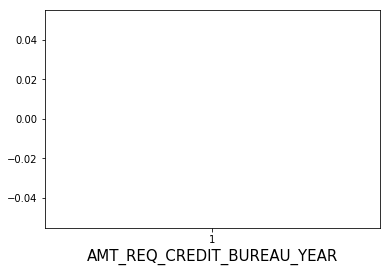

In [3]:
# 先篩選數值型的欄位
dtype_select = [np.dtype('int64'), np.dtype('float64')]

numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])

# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(app_train[numeric_columns].columns[list(app_train[numeric_columns].apply(lambda x:len(x.unique())!=2))])
print('Numbers of remain columns = ', len(numeric_columns))

# 檢視這些欄位的數值範圍
for col in numeric_columns:
    plt.figure()
    plt.boxplot(app_train[col])
    plt.xlabel(col, size = 15)


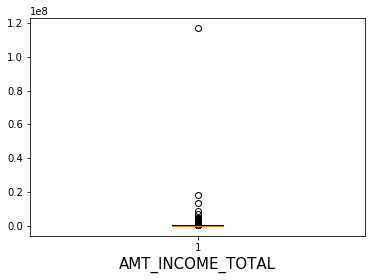

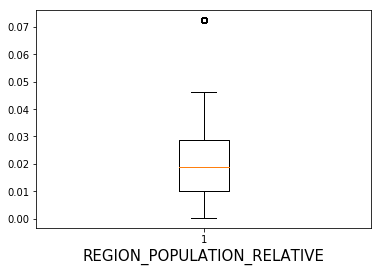

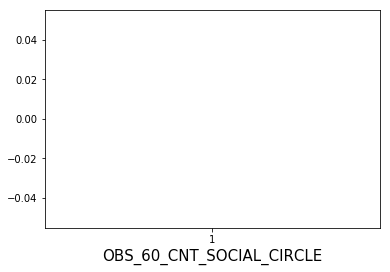

In [4]:
# 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

# AMT_INCOME_TOTAL
# REGION_POPULATION_RELATIVE
# OBS_60_CNT_SOCIAL_CIRCLE
suspicious_columns = ['AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'OBS_60_CNT_SOCIAL_CIRCLE']
for col in suspicious_columns:
    plt.figure()
    plt.boxplot(app_train[col])
    plt.xlabel(col, size = 15)

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


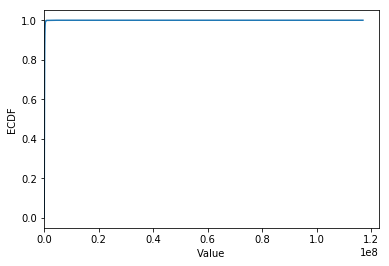

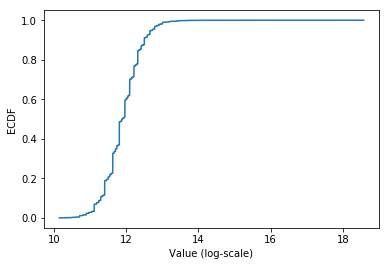

In [5]:
# 最大值離平均與中位數很遠
print(app_train['AMT_INCOME_TOTAL'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
## 1.計算各值之數量  2.依據值隻大小排序  3.累加
cdf = app_train['AMT_INCOME_TOTAL'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

# 改變 y 軸的 Scale, 讓我們可以正常檢視 ECDF
plt.plot(np.log(list(cdf.index)), cdf/cdf.max())
plt.xlabel('Value (log-scale)')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64


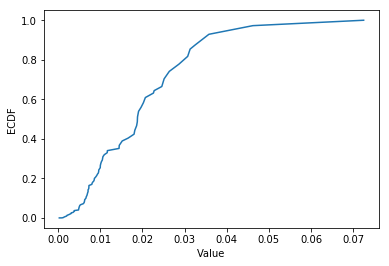

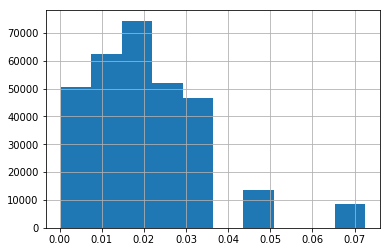

0.000290        2
0.000533       39
0.000938       28
0.001276      558
0.001333      235
0.001417      467
0.002042     1642
0.002134     1051
0.002506      944
0.003069     1783
0.003122     1147
0.003541      627
0.003813     1616
0.003818     1212
0.004849     1038
0.004960     3300
0.005002     1068
0.005084     1482
0.005144      967
0.005313     1218
0.006008     1796
0.006207     1936
0.006233     1087
0.006296     1225
0.006305     1672
0.006629     2818
0.006671     1653
0.006852     2435
0.007020     4105
0.007114     1684
            ...  
0.010556     2177
0.010643     3012
0.010966     3110
0.011657     3080
0.011703     3252
0.014464     3422
0.014520     4785
0.015221     6824
0.016612     4408
0.018029     6167
0.018209     6052
0.018634     7038
0.018801     6108
0.018850     7668
0.019101     8694
0.019689     6172
0.020246     7178
0.020713     8066
0.022625     6943
0.022800     3807
0.024610     6404
0.025164    11950
0.026392    11601
0.028663    11157
0.030755  

In [6]:
# 最大值落在分布之外
print(app_train['REGION_POPULATION_RELATIVE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index()
# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64


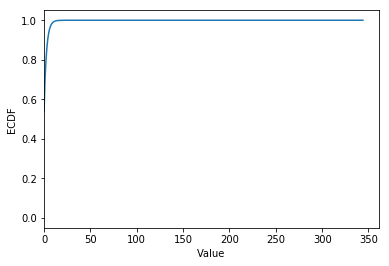

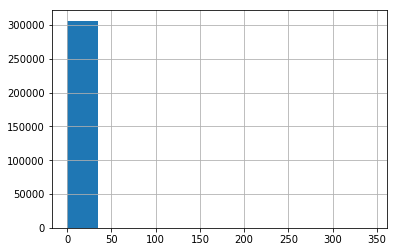

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64


In [7]:
# 最大值落在分布之外
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe())

# 繪製 Empirical Cumulative Density Plot (ECDF)
cdf = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim([cdf.index.min() * 0.95, cdf.index.max() * 1.05])
plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍
plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()
print(app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False))

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

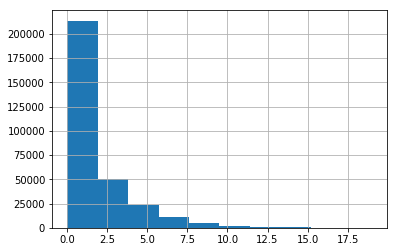

In [8]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製
loc_a = app_train.OBS_60_CNT_SOCIAL_CIRCLE<20
loc_b = 'OBS_60_CNT_SOCIAL_CIRCLE'

app_train.loc[loc_a, loc_b].hist()
plt.show()